# PCA Analysis of ~16k 32x32 Postage Stamps of DC2 data

This notebook is heavily influenced by `Dimensionality.ipynb` from Prof. Kirkby's **ML & Stats Class**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd 
from sklearn import decomposition
import pickle

### Load the data

In [2]:
postage_stamp_arr = np.array(pickle.load(open("/global/cscratch1/sd/mdowicz/NF_deblender/Data/Interim/postage_stamp_pixel_array", "rb")))

In [3]:
np.shape(postage_stamp_arr)

(16384, 32, 32)

Reshape the data from (nimages, ncols, nrows) to (nimages, ncols$\times$nrows) & convert to a pandas dataframe (`pd.DataFrame`)

In [4]:
postage_stamp_flat = postage_stamp_arr.reshape(-1,1024)
print(postage_stamp_flat.shape)

post_stamp_flat_df = pd.DataFrame(postage_stamp_flat)
print(post_stamp_flat_df)

(16384, 1024)
           0         1         2         3         4         5         6     \
0      0.100635 -0.043460 -0.126487  0.040964 -0.029051  0.007733  0.053472   
1     -0.050656 -0.012187  0.021953  0.005427 -0.012707  0.063048  0.002238   
2      0.067719  0.027204 -0.015359 -0.028593  0.003134  0.013540 -0.010499   
3     -0.033581  0.060758  0.015222  0.028073  0.058039  0.057408 -0.082839   
4      0.041569  0.011726  0.046162 -0.108967  0.068342 -0.012667 -0.010946   
...         ...       ...       ...       ...       ...       ...       ...   
16379 -0.070293 -0.052549 -0.029174 -0.108231 -0.049083  0.122390  0.115686   
16380 -0.002021 -0.054376  0.082990  0.000048 -0.032016  0.013154  0.055116   
16381 -0.001121 -0.067146  0.010682 -0.022794 -0.055654  0.038856  0.023847   
16382 -0.041940 -0.000727  0.111778 -0.041867  0.019040 -0.032877  0.017910   
16383  0.007706 -0.007079  0.019296  0.030333 -0.019467 -0.085733  0.139461   

           7         8         9     

### Data Dimensionality

We call the number of features (columns) in a dataset its _"dimensionality"_. In order to learn how different features are related, we need enough samples to get a complete picture.

For example, imagine splitting each feature at its median value then, at a minimum, we would like to have at least one sample in each of the resulting $2^{D}$ bins ( $D$ = dimensionality = # of features = # of columns). This is a very low bar and only requires 8 samples with $D=3$, but requires $2^{30} > 1$ billion samples with $D=30$.

To get a feel for how well sampled your dataset is, estimate how many bins you could split each feature (axis) into and end up with 1 sample per bin (assuming that features are uncorrelated). A value $< 2$ fails our minimum test above and anything $< 5$ is a potential red flag.

In [5]:
stats = []
name = 'postage_stamps'

N, D1, D2= (postage_stamp_arr).shape
stats.append([name, N, D1*D2, N ** (1 / (D1*D2))])
pd.DataFrame(stats, columns=('Dataset', 'N', 'D', 'N**(1/D)')).round(3)

# For fun: get the raw pixel values and do this again bc I don't think what I did, by getting D1 & D2 is correct, so I'm concerned this 
# isn't an accurate representation of our data :-)

,Dataset,N,D,N**(1/D)
0,postage_stamps,16384,1024,1.01


In [6]:
stats = []
name = 'postage_stamps_flat'

N, D = (post_stamp_flat_df).shape
stats.append([name, N, D, N ** (1 / D)])
pd.DataFrame(stats, columns=('Dataset', 'N', 'D', 'N**(1/D)')).round(3)

# Checks out!

,Dataset,N,D,N**(1/D)
0,postage_stamps_flat,16384,1024,1.01


This `postage_stamps` data seems to be severely undersampled with N=16384, D=1024 (assuming I did the calculation above right)

## Linear Decompositions

The goal of a linear decomposition is to automatically identify linear combinations of the original features that account for most of the variance in the data. Note that we are using variance (spread) as a proxy for _"useful information"_, so it is essential that the relative normalization of our features is meaningful. 

If we represent our data with a $N \times D$ matrix $X$, then a linear decomposition can be represented as the following matrix multiplication:

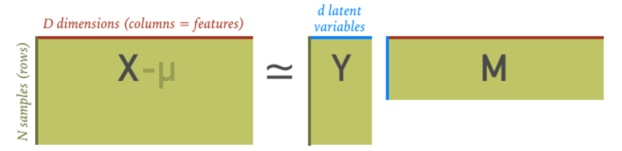

The $N \times d$ matrix $Y$ is a reduced representation of the original data $X$, with $d < D$ new features that are linear combinations of the original $D$ feature. We call the new features _"latent variables"_, since they were already present in $X$ but only implicitly.

The $d \times D$ matrix $M$ specifies the relationship between the old and new features: each column is a unit vector for a new feature in terms of the old features. Note that $M$ is not square when $d < D$ and unit vectors are generally not mutually orthogonal (except for the PCA method).


A linear decomposition is not exact (hence the $\simeq$ above) and there is no _"best"_ prescription for determining $Y$ and $M$. Below we review the most popular prescriptions implemented in the [sklearn.decomposition](https://scikit-learn.org/stable/modules/decomposition.html) module.


All methods require that you specify the number of latent variables $d$ (but you can easily experiment with different values) and are called using (method = PCA, FactorAnalysis, NMF, FastICA):

```
    fit = decomposition.method(n_components=d).fit(X)
```

The resulting decomposition into $Y$ and $M$ is given by:

```
    M = fit.components_
    Y = fit.transform(X)
```

except for FastICA, where `M = fit.mixing_.T`

When $d < D$, we refer to the decomposition as a _"dimensionality reduction"_. A useful visualization of how effectively the latent variables capture the interesting information in the original data is to calculate: 

$$ X^{'} = YM$$

which approximately reconstructs the original data, and compare rows (samples) of $X^{'}$ with the original $X$. They will not agree exactly, but if the differences seem uninteresting (e.g., look like noise), then the dimensionality reduction was successful and you can use $Y$ instead of $X$ for subsequent analysis. 

We will use the function below to demonstrate each of these in turn (but you can ignore its details unless you interested):

In [7]:
def demo(method='PCA', d=2, data= post_stamp_flat_df):
    
    X = data.values 
    N, D = X.shape
    
    if method is 'NMF':
        # All data must be postive.
        assert np.all(X > 0)
        # Analysis includes the mean.
        mu = np.zeros(D)
    else:
        mu = np.mean(X, axis=0)
    fit = eval('decomposition.' + method)(n_components=d).fit(X)
    
    # Check that decomposition has the expected shape.
    if method is 'FastICA':
        M = fit.mixing_.T
    else:
        M = fit.components_
    assert M.shape == (d, D)
    Y = fit.transform(X)
    assert Y.shape == (N, d)
    
    # Reconstruct X - mu from the fitted Y, M.
    Xr = np.dot(Y, M) + mu
    assert Xr.shape == X.shape
    
    # Plots pairs of latent vars.
    columns = ['y{}'.format(i) for i in range(d)]
    sns.pairplot(pd.DataFrame(Y, columns=columns))
    plt.show()
    
    # Compare a few samples from X and Xr.
    fig = plt.figure(figsize=(8.5, 4))
    for i,c in zip((0, 6, 7), sns.color_palette()):
        plt.plot(X[i], '.', c=c, ms=3, alpha=0.5)
        plt.plot(Xr[i], '-', c=c, lw=2)
    plt.xlim(-0.5, D+0.5)
    plt.xlabel('Feature #')
    plt.ylabel('Feature Value')
    label = '{}(d={}): $\sigma = {:.2f}$'.format(method, d, np.std(Xr - X))
    plt.text(0.95, 0.9, label, horizontalalignment='right', fontsize='x-large', transform=plt.gca().transAxes)

## Principal Component Analysis

PCA is the most used method for dimensionality reduction. The decomposition is uniquely specified by the following prescription (more details [here](https://en.wikipedia.org/wiki/Principal_component_analysis#Computing_PCA_using_the_covariance_method):

* Find the eigenvectors and eigenvalues of 
$$C = \frac{1}{N - 1}X^{T}X$$
which is an [empirical estimate](https://en.wikipedia.org/wiki/Covariance#Calculating_the_sample_covariance) of the covariance matrix for the data.

* Construct $M$ out of the eigenvectors, ordered by decreasing eigenvalue (which are all positive) and solve the resulting linear equations for $Y$. At this point the decomposition is exact with $d = D$.

* Shrink $Y$ and $M$ from $D$ to $d$ rows ($M$) or columns ($Y$), which makes the decomposition approximate while discarding the least amount of variance in the original data (which we use as a proxy for _"useful information"_).

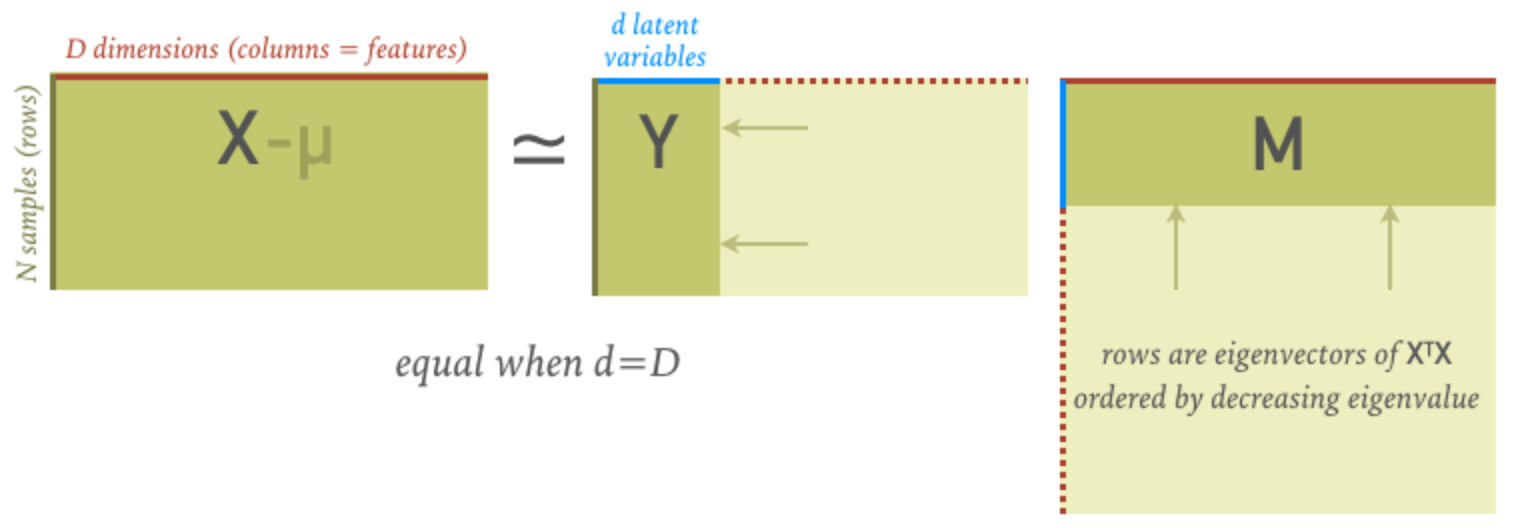

The full $M$ matrix (before shrinking $D \rightarrow d$) is orthogonal $M^{T} = M^{-1}$ and satisfies $X^{T}X = M^{T}\Lambda M$, where $\Lambda$ is a diagonal matrix of the decreasing eigenvalues. Note that this description glosses over some details.

The resulting latent variables are _statisticall uncorrelated_ (which is a weaker statement than _statistically independent_), ie., the [correlation coefficients](https://en.wikipedia.org/wiki/Correlation_coefficient) between different columns of $Y$ are approximately zero:

$$\rho\,(j,k) = \frac{Y_{j} \cdot Y_{k}}{|Y_{j}| |Y_{k}|} \simeq 0. $$

The PCA demonstration below shows a pairplot of the latent variables from a $d = 2$ decomposition, followed by a reconstruction of some samples (red curves) compared with the originals (red points).

Note that the reconstructed samples are in some sense _better_ than the originals since the original noise was associated with a small eigenvalue that was trimmed!

In [8]:
#demo('PCA', d=1)

In [ ]:
demo('PCA', d=2) 

In [10]:
#demo('PCA', d=3) var = 4.33

In [11]:
#demo('PCA', d=4) var = 4.09

In [12]:
#demo('PCA', d=5) var = 3.85

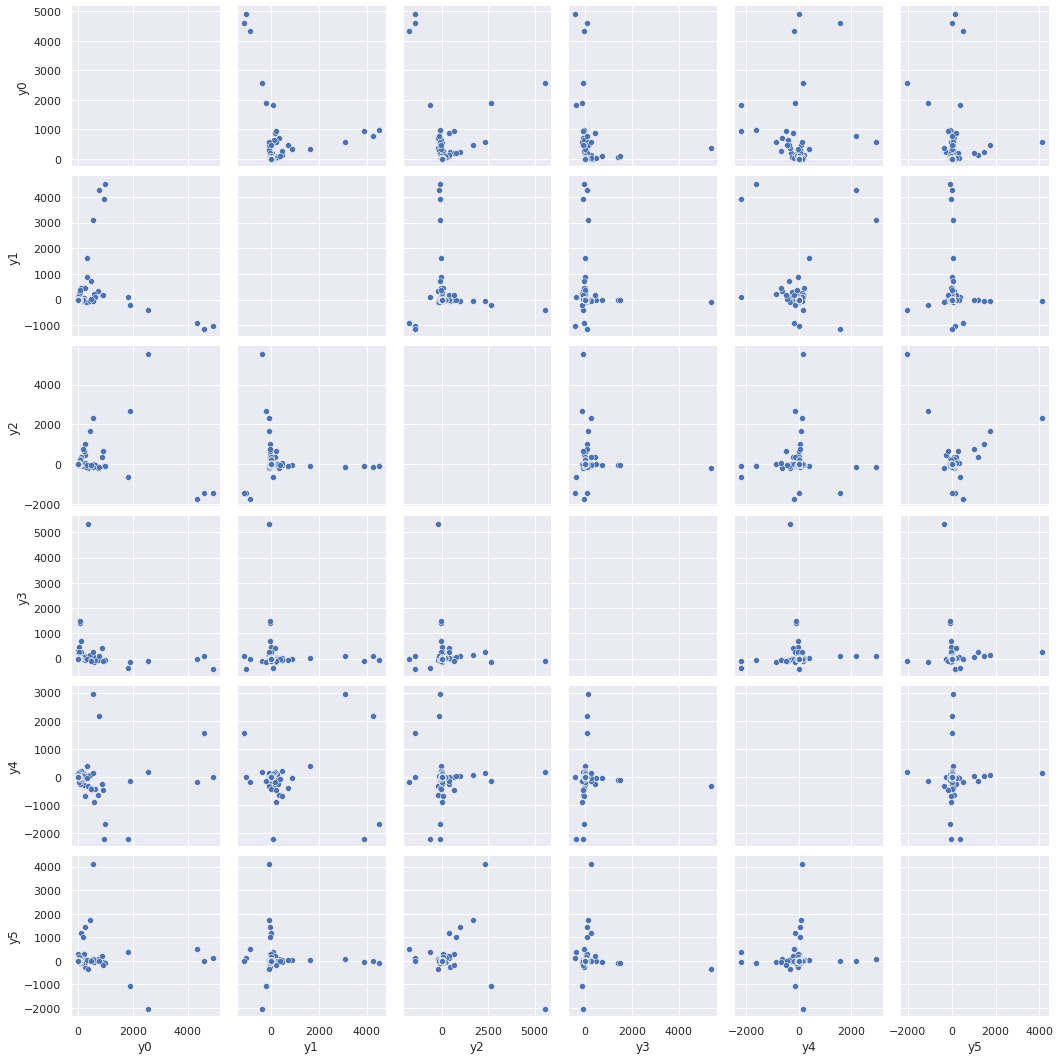

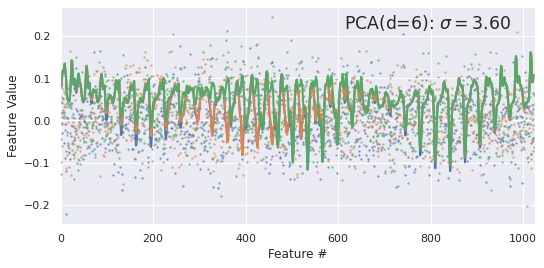

In [14]:
demo('PCA', d=6) #3.60

In [ ]:
#demo('PCA', d=7)

In [ ]:
# postage_stamp_arr_cut = postage_stamp_arr[0:5000]
# postage_stamp_flat = postage_stamp_arr_cut.reshape(-1,1024)
# print(postage_stamp_flat.shape)

# post_stamp_flat_df = pd.DataFrame(postage_stamp_flat)

In [ ]:
# def demo(method='PCA', d=2, data= post_stamp_flat_df):
    
#     X = data.values 
#     N, D = X.shape
    
#     if method is 'NMF':
#         # All data must be postive.
#         assert np.all(X > 0)
#         # Analysis includes the mean.
#         mu = np.zeros(D)
#     else:
#         mu = np.mean(X, axis=0)
#     fit = eval('decomposition.' + method)(n_components=d).fit(X)
    
#     # Check that decomposition has the expected shape.
#     if method is 'FastICA':
#         M = fit.mixing_.T
#     else:
#         M = fit.components_
#     assert M.shape == (d, D)
#     Y = fit.transform(X)
#     assert Y.shape == (N, d)
    
#     # Reconstruct X - mu from the fitted Y, M.
#     Xr = np.dot(Y, M) + mu
#     assert Xr.shape == X.shape
    
#     # Plots pairs of latent vars.
#     columns = ['y{}'.format(i) for i in range(d)]
#     sns.pairplot(pd.DataFrame(Y, columns=columns))
#     plt.show()
    
#     # Compare a few samples from X and Xr.
#     fig = plt.figure(figsize=(8.5, 4))
#     for i,c in zip((0, 6, 7), sns.color_palette()):
#         plt.plot(X[i], '.', c=c, ms=3, alpha=0.5)
#         plt.plot(Xr[i], '-', c=c, lw=2)
#     plt.xlim(-0.5, D+0.5)
#     plt.xlabel('Feature #')
#     plt.ylabel('Feature Value')
#     label = '{}(d={}): $\sigma = {:.2f}$'.format(method, d, np.std(Xr - X))
#     plt.text(0.95, 0.9, label, horizontalalignment='right', fontsize='x-large', transform=plt.gca().transAxes)

In [ ]:
#demo('PCA', d=1)